# Extended Stochastic Block Model for Recommendations - Tutorial (draft 1.0)

#### The following notebook is a preliminary tutorial on how to use the module "esbmr" for bipartite network, a blockmodel-based recommender system which allows to make inference on cluster assignments of users and items as well as on their block interactions.

#### The module runs a collapsed Gibbs sampling algorithm. Coverged is assesed through the computation of the log-likelihood.

## Model formulation
ESBMR can be seen as a Bayesian latent class model for bipartite networks (networks with two separate entity, i.e. users and items) and builds on the ESBM of Legramanti et al. (2020). The user-item interactions $y_{u,i}$ are drawn from a Poisson distribution, with parameter $\theta_{z_u,z_i}$, where $z_u$ is the cluster assignment of user $u$ and $z_i$ is the cluster assignment of item $i$.

In this way, the model discovers latent block structures in user and item entities. At the same time, it estimates the block interaction matrix $\Theta = \{\theta_{h,k}\}_{h,k}$: for each pair of user-item clusters, the higher is the value of $\theta_{h,k}$, the higher will be their affinity or probability of interactions. Thanks to cluster assignments and block interaction parameters, we can set up an accurate and identifiable recommender system.

The generative model can be summed up as follows:
1. For each user $u=1,...,U$:
- Draw a cluster assignment $z_u$ according to its prior.
2. For each item $i = 1,...,I$:
- Draw a cluster assignment $z_i$ according to its prior.
3. For each pair of clusters $h,k$:
- Sample block interaction parameter: $\theta_{h,k} \sim \text{Gamma}(a,b)$
4. For each pair of user-item $u,i$:
- Sample the interaction value: $y_{u,i} \sim \text{Poisson}(\theta_{z_u,z_i})$


In [2]:
from esbmr import esbmr # importing the module

import pandas as pd
import numpy as np 
import random
from numpy import matlib
from scipy.special import betaln
from scipy.special import gammaln
import time
import matplotlib.pyplot as plt

## Object instantiation
The model allows for the choice of Bayesian nonparametric priors on cluster assignments: in this way, the number of clusters is fully inferred from the data, giving the model high flexibility. The priors allowed on cluster assignments are: Dirichlet-Multinomial (DM), Dirichlet process (DP), Pitman-Yor process (PY) and Gnedin process (GN).

When an object "esbmr" is instantiated, if no arguments are passed, the priors on cluster assignments are automatically set to the Dirichlet process prior. In addition, the hyperparameters $a$ and $b$ are set to 1, to induce a prior with high density near zero.

In [3]:
model = esbmr()
print(f"Prior on cluster assignments of users: {model.prior_u}\nPrior on cluster assignments of items: {model.prior_i}")

Prior on cluster assignments of users: DP
Prior on cluster assignments of items: DP


## Implementation without covariates
The method "fit" executes a collapsed Gibbs sampler, with user-specified number of iterations.\
 If no covariates are passed, inference will be conducted on network data only.

The required input of the model is an adjacency matrix $Y$ of user-item interactions, with implicit or explicit feedback.

In [5]:
Y = pd.read_csv("ratings.csv")
Y = np.array(Y) # data: 49 users and 130 items

model.fit(Y,100)

------------------
Initial log-likelihood: -2305.861213177008
------------------
Gibbs Sampling simulation starts.
Iteration 0 complete. Log-likelihood: 1942.4998730599136.
Iteration 10 complete. Log-likelihood: 2289.9869624320527.
Iteration 20 complete. Log-likelihood: 2325.799706443189.
Iteration 30 complete. Log-likelihood: 2321.0164540783917.
Iteration 40 complete. Log-likelihood: 2310.826276617979.
Iteration 50 complete. Log-likelihood: 2322.5555570270444.
Iteration 60 complete. Log-likelihood: 2325.586072986455.
Iteration 70 complete. Log-likelihood: 2317.3096147518127.
Iteration 80 complete. Log-likelihood: 2313.1761095166567.
Iteration 90 complete. Log-likelihood: 2317.7206172123874.
Runtime: 10.966681
Block-interactions computed.


## Block interactions:
At the end on the MCMC procedure, the block interaction matrix $\Theta$ is computed, based on the estimated cluster assignments.

Please note that, for the moment, we only take the last value of the MCMC to build our final estimates.


In [6]:
model.theta_est # block-interaction parameters

array([[8.69061414e-03, 1.48571429e-01, 2.71186441e-01, 3.38000000e+01,
        1.00000000e-01, 6.66666667e-02],
       [3.26644890e-03, 1.19266055e-01, 4.05405405e-01, 1.10526316e+01,
        1.05263158e-01, 1.05263158e-01],
       [2.91666667e-01, 1.42857143e-01, 3.33333333e-01, 1.00000000e+00,
        5.00000000e-01, 5.00000000e-01],
       [3.33333333e-02, 4.28571429e-01, 3.33333333e-01, 1.50000000e+00,
        1.00000000e+00, 1.00000000e+00]])

## Implementation with covariates
In addition to the adjacency matrix $Y$, it is possible to provide categorical, binary, count-type or continuous covariates to the model, which ultimately improves the overall performance.

Categorical, binary, count or continuous covariates can be provided both for user entity and for item entity: it sufficies to specify their type in a specific parameter of the "fit" method.

In the following toy example, we provide two covariates for the user entity. Priors on cluster assignments are set to GN and appropriate parameters are passed.

In [7]:
x1 = np.array([ 1.04, -1.93,  0.61, -1.04,  2.53, -2.33,  0.63,  0.4 ,  0.09,
       -0.9 , -0.5 , -0.52, -0.6 , -0.3 ,  0.41,  0.41,  1.15, -0.8 ,
       -0.42, -0.4 , -0.63,  0.89,  0.01, -0.91,  0.12, -0.83,  0.01,
       -0.64, -2.2 , -0.62,  0.72,  0.45, -0.56,  0.77,  0.81, -0.88,
       -0.39,  0.2 , -0.38,  0.69, -2.11, -0.57, -0.74,  0.79,  0.3 ,
       -0.32,  0.44,  1.09,  0.11]) # continuous covariate for users

x2 = np.array([[5, 8, 6, 6, 3, 8, 2, 6, 4, 6, 5, 3, 3, 9, 5, 6, 9, 0, 3, 4, 0, 9,
       2, 2, 6, 8, 2, 5, 1, 6, 8, 9, 3, 1, 7, 9, 7, 1, 4, 2, 7, 5, 2, 0,
       3, 3, 7, 8, 2]]) # count-type covariate for users

x = np.empty(shape= (2,Y.shape[0]))

mod1 = esbmr(prior_u = "GN", prior_i = "GN", beta = 0.1, components = 2, sigma = 0.4, gamma = 0)
mod1.fit(Y, 100, xu = x, xi = None, xu_type = ["cont","count"], xi_type = None, verbose = False)

mod1.theta_est # block interaction parameters

------------------
2 covariates for 'user' entity provided:
 - Continuous covariate 0 for users preprocessed.
 - Count-type covariate 1 for users preprocessed.
------------------
Initial log-likelihood: -2305.861213177008
------------------
Gibbs Sampling simulation starts.
Iteration 0 complete. Log-likelihood: 1907.3715715589296.
Iteration 10 complete. Log-likelihood: 2189.8518221831664.
Iteration 20 complete. Log-likelihood: 2313.8238349010576.
Iteration 30 complete. Log-likelihood: 2312.3267760242334.
Iteration 40 complete. Log-likelihood: 2312.200395875206.
Iteration 50 complete. Log-likelihood: 2314.309100593839.
Iteration 60 complete. Log-likelihood: 2302.0942727824677.
Iteration 70 complete. Log-likelihood: 2311.9978611366346.
Iteration 80 complete. Log-likelihood: 2312.2778573061655.
Iteration 90 complete. Log-likelihood: 2315.235448491328.
Runtime: 14.15685
Block-interactions computed.


array([[7.46911807e-03, 1.30434783e-01, 3.34193548e+01],
       [2.02736949e-03, 1.30630631e-01, 1.04444444e+01],
       [2.99145299e-01, 7.14285714e-02, 1.00000000e+00],
       [1.70940171e-02, 5.00000000e-01, 1.50000000e+00]])

### Convergence diagnostics
We plot a term which is proportional to the log-likelihood in order to assess the convergence of the model. 

Further diagnostics can be delivered for larger networks.

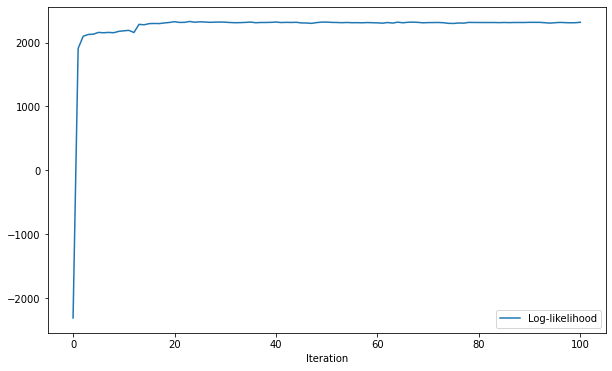

In [20]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (10,6))
ax.plot(mod1.ll, label = "Log-likelihood")
plt.xlabel("Iteration")
ax.legend();